In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

import numpy as np
import pandas as pd
from time import time

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, BatchNormalization as BatchNorm
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

from pmdarima.arima import auto_arima, ADFTest

import matplotlib.pyplot as plt

In [2]:
from nba_api.stats.endpoints import (playergamelog, leagueseasonmatchups, boxscoretraditionalv2,
                                     commonteamroster, teamgamelogs, leaguedashptteamdefend,
                                     teamestimatedmetrics)

from nba_api.stats.static import teams, players
from nba_api.stats.library.parameters import SeasonAll

In [3]:
def fetch_players_id(players_full_name: str) -> int:
    """
    Get players ID given full name

    :param: players_full_name: player's full name
    :return: player's ID
    """
    try:
        players_id = players.find_players_by_full_name(players_full_name)[0]["id"]
    except IndexError:
        print(f"WARNING: {players_full_name} does not have a player ID!")
        players_id = None

    return players_id

def fetch_players_game_logs_df(players_id: str, season: str) -> pd.DataFrame:
    """
    Access the PlayerGameLog module to fetch the game logs df of given player

    :param players_id: player ID
    :return: the given player's game logs in df format
    """
    players_game_log = playergamelog.PlayerGameLog(player_id=players_id, season=season,
                                                   season_type_all_star="Regular Season")
    players_game_logs_df = players_game_log.get_data_frames()[0]
    try:
        players_game_logs_df =  players_game_logs_df.iloc[:num_games+1, :]
    except:
        players_game_logs_df = players_game_logs_df

    return players_game_logs_df

In [4]:
metrics_21 = pd.read_csv("data/seasonal_data/2021/defensive_metrics_21.csv", index_col=0)
metrics_22 = pd.read_csv("data/seasonal_data/2022/defensive_metrics_22.csv", index_col=0)
metrics_23 = pd.read_csv("data/seasonal_data/2023/defensive_metrics_23.csv", index_col=0)

In [5]:
def convert_to_float32(df: pd.DataFrame, cols: list=None):
    """
    """
    df[cols] = df[cols].astype(np.float32)
    
    return df

In [6]:
nba_teams = teams.get_teams()
static_team_info = pd.DataFrame(nba_teams)
all_teams_id = static_team_info["id"].values

In [7]:
id_abb_lut = dict(zip(static_team_info["abbreviation"], static_team_info["id"]))

In [8]:
# atl = teamgamelogs.TeamGameLogs(team_id_nullable=1610612737, season_nullable="2022-23").get_data_frames()[0]

In [9]:
# df = leaguedashptteamdefend.LeagueDashPtTeamDefend(
#                                               defense_category="2 Pointers",
#                                               per_mode_simple="PerGame",
#                                               season="2020-21",
#                                               season_type_all_star="Regular Season",
#                                               season_segment_nullable="Post All-Star"
#                                               ).get_data_frames()[0]

In [10]:
# df.to_csv("data/seasonal_data/2021/post_asb_2pt_21.csv")

In [11]:
def get_opp_id(matchup: str):
    matchup_split = matchup.split(" ")
    opp_abb = matchup_split[2]
    team_id = static_team_info[static_team_info["abbreviation"]==opp_abb]["id"].values[0]
    
    return team_id

def add_rest_days(players_game_logs_df: pd.DataFrame) -> pd.DataFrame:
    """
    Add rest days column

    :param players_game_logs_df: player's game logs df
    :return: player's game logs df w/ rest days
    """
    players_game_logs_df["GAME_DATE"] = players_game_logs_df["GAME_DATE"].apply(lambda x: x.split(" "))
    players_game_logs_df["GAME_DATE"] = players_game_logs_df["GAME_DATE"].apply(convert_to_timestamp)
    players_game_logs_df = players_game_logs_df.sort_values(by=["GAME_DATE"], ascending=False)
    players_game_logs_df["REST_DAYS"] = players_game_logs_df["GAME_DATE"].diff(periods=-1)
    players_game_logs_df = players_game_logs_df.iloc[:-1, :]
    players_game_logs_df.loc[:, "REST_DAYS"] = players_game_logs_df["REST_DAYS"].dt.days

    return players_game_logs_df

def add_home_away_columns(players_game_logs_df: pd.DataFrame) -> pd.DataFrame:
    """
    Add one_hot encoding home or away bool columns

    :param players_game_logs_df: player's game logs df
    :return: player's game logs df w/ home & away columns
    """
    players_game_logs_df.loc[:, ("HOME", "AWAY")] = tf.one_hot(players_game_logs_df["MATCHUP"].\
                                                    apply(detect_home_or_away_games), 2)

    return players_game_logs_df

def detect_home_or_away_games(game: str):
    """
    Detect if a game is on home court or away
    """
    return 1 if "@" in game else 0

def convert_to_timestamp(date_string: str) -> pd.Timestamp:
    """
    Convert a date in string format to pd.Timestamp format
    """
    months_dict = init_months_dict()
    date = pd.Timestamp(f"{date_string[2]}-{months_dict[date_string[0]]}-{date_string[1][:-1]}")

    return date

def init_months_dict() -> dict:
    """
    Create months dictionary
    """
    months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
    months_dict = dict(zip(months, range(1, 13)))

    return months_dict

In [12]:
def merge_defensive_stats(season: str, game_log: pd.DataFrame,
                          defensive_stats: list, metrics: pd.DataFrame=None) -> pd.DataFrame:
    """
    """
    all_star_date = f"20{season}-02-14"
    
    pre_asb = game_log[game_log["GAME_DATE"] < all_star_date].merge(defensive_stats[0], on="TEAM_ID")
    
    post_asb = game_log[game_log["GAME_DATE"] >= all_star_date].merge(defensive_stats[1], on="TEAM_ID")
    
    complete_log = pd.concat([pre_asb, post_asb])
    
    if metrics is not None:
        complete_log = complete_log.merge(metrics, on="TEAM_ID")
    
    return complete_log

### 2023 Season

In [13]:
name = "Ja Morant"
player = fetch_players_id(name)
log_23 = fetch_players_game_logs_df(player, "2022-23")
log_23["TEAM_ID"] = log_23["MATCHUP"].apply(get_opp_id)
log_23 = add_rest_days(add_home_away_columns(log_23))

pre_teams_d_23 = pd.read_csv("data/seasonal_data/2023/defense_pre_ASB_23.csv", index_col=0)
post_teams_d_23 = pd.read_csv("data/seasonal_data/2023/defense_post_ASB_23.csv", index_col=0)

pre_teams_3pt_23 = pd.read_csv("data/seasonal_data/2023/pre_asb_3pt_23.csv", index_col=0)
post_teams_3pt_23 = pd.read_csv("data/seasonal_data/2023/post_asb_3pt_23.csv", index_col=0)

pre_teams_2pt_23 = pd.read_csv("data/seasonal_data/2023/pre_asb_2pt_23.csv", index_col=0)
post_teams_2pt_23 = pd.read_csv("data/seasonal_data/2023/post_asb_2pt_23.csv", index_col=0)

player_23 = merge_defensive_stats(season="23", game_log=log_23,
                                  defensive_stats=[pre_teams_d_23, post_teams_d_23],
                                  metrics=metrics_23)

player_23 = merge_defensive_stats(season="23", game_log=player_23,
                                  defensive_stats=[pre_teams_3pt_23, post_teams_3pt_23])

player_23 = merge_defensive_stats(season="23", game_log=player_23,
                                  defensive_stats=[pre_teams_2pt_23, post_teams_2pt_23])

2023-05-17 08:40:42.761908: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 08:40:42.766618: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8ad01f8540 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-17 08:40:42.766631: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


### 2022 Season

In [14]:
log_22 = fetch_players_game_logs_df(player, "2021-22")
log_22["TEAM_ID"] = log_22["MATCHUP"].apply(get_opp_id)
log_22 = add_rest_days(add_home_away_columns(log_22))
all_star_22 = "2022-02-14"

pre_teams_d_22 = pd.read_csv("data/seasonal_data/2022/defense_pre_ASB_22.csv", index_col=0)
post_teams_d_22 = pd.read_csv("data/seasonal_data/2022/defense_post_ASB_22.csv", index_col=0)

pre_teams_3pt_22 = pd.read_csv("data/seasonal_data/2022/pre_asb_3pt_22.csv", index_col=0)
post_teams_3pt_22 = pd.read_csv("data/seasonal_data/2022/post_asb_3pt_22.csv", index_col=0)

pre_teams_2pt_22 = pd.read_csv("data/seasonal_data/2022/pre_asb_2pt_22.csv", index_col=0)
post_teams_2pt_22 = pd.read_csv("data/seasonal_data/2022/post_asb_2pt_22.csv", index_col=0)

player_22 = merge_defensive_stats(season="22", game_log=log_22,
                                  defensive_stats=[pre_teams_d_22, post_teams_d_22],
                                  metrics=metrics_22)

player_22 = merge_defensive_stats(season="22", game_log=player_22,
                                  defensive_stats=[pre_teams_3pt_22, post_teams_3pt_22])

player_22 = merge_defensive_stats(season="22", game_log=player_22,
                                  defensive_stats=[pre_teams_2pt_22, post_teams_2pt_22])

### 2021 Season

In [15]:
log_21 = fetch_players_game_logs_df(player, "2020-21")
log_21["TEAM_ID"] = log_21["MATCHUP"].apply(get_opp_id)
log_21 = add_rest_days(add_home_away_columns(log_21))
all_star_21 = "2021-02-14"

pre_teams_d_21 = pd.read_csv("data/seasonal_data/2021/defense_pre_ASB_21.csv", index_col=0)
post_teams_d_21 = pd.read_csv("data/seasonal_data/2021/defense_post_ASB_21.csv", index_col=0)

pre_teams_3pt_21 = pd.read_csv("data/seasonal_data/2021/pre_asb_3pt_21.csv", index_col=0)
post_teams_3pt_21 = pd.read_csv("data/seasonal_data/2021/post_asb_3pt_21.csv", index_col=0)

pre_teams_2pt_21 = pd.read_csv("data/seasonal_data/2021/pre_asb_2pt_21.csv", index_col=0)
post_teams_2pt_21 = pd.read_csv("data/seasonal_data/2021/post_asb_2pt_21.csv", index_col=0)

player_21 = merge_defensive_stats(season="21", game_log=log_21,
                                  defensive_stats=[pre_teams_d_21, post_teams_d_21],
                                  metrics=metrics_21)

player_21 = merge_defensive_stats(season="21", game_log=player_21,
                                  defensive_stats=[pre_teams_3pt_21, post_teams_3pt_21])

player_21 = merge_defensive_stats(season="21", game_log=player_21,
                                  defensive_stats=[pre_teams_2pt_21, post_teams_2pt_21])

In [16]:
complete_log = pd.concat([player_21, player_22, player_23]).sort_values(by=["GAME_DATE"], ascending=False)
complete_log.columns

Index(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M_x', 'FG3A_x', 'FG3_PCT_x', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'TEAM_ID', 'HOME', 'AWAY',
       'REST_DAYS', 'D_FGM', 'D_FGA', 'D_FG_PCT', 'NORMAL_FG_PCT',
       'PCT_PLUSMINUS', 'E_PACE', 'E_DEF_RATING', 'FG3M_y', 'FG3A_y',
       'FG3_PCT_y', 'NS_FG3_PCT', 'PLUSMINUS_x', 'FG2M', 'FG2A', 'FG2_PCT',
       'NS_FG2_PCT', 'PLUSMINUS_y', 'FREQ'],
      dtype='object')

In [17]:
predictors = ["MIN", "FGA", "FG3A_x", "FTA", "HOME", "AWAY", "REST_DAYS",
              "D_FGM", "D_FGA", "D_FG_PCT", "PCT_PLUSMINUS",
              "FG3M_y", "FG3A_y", "FG3_PCT_y", "NS_FG3_PCT", "PLUSMINUS_x",
              "FG2M", "FG2A", "FG2_PCT", "NS_FG2_PCT", "PLUSMINUS_y",
              "E_PACE", "E_DEF_RATING"]

label1 = ["PTS"]

In [18]:
game_to_predict = 10

X, y = complete_log[predictors].astype(np.float32), complete_log[label1].astype(np.float32)
xtrain, ytrain = X.iloc[game_to_predict+1:, :].values, y.iloc[game_to_predict+1:, :].values
xtest, ytest = X.iloc[:game_to_predict, :].values, y.iloc[:game_to_predict, :].values

In [19]:
x_scaler = MinMaxScaler()
x_scaler.fit(xtrain)
xtrain_scaled = x_scaler.transform(xtrain)

y_scaler = MinMaxScaler()
y_scaler.fit(ytrain)
ytrain_scaled = y_scaler.transform(ytrain)

In [20]:
model = Sequential()
model.add(Dense(200, activation="relu", input_shape=(len(predictors), )))
model.add(Dense(200, activation="relu", batch_size=24, kernel_regularizer=regularizers.l1(1e-3)))
model.add(Dropout(0.2)) 
model.add(Dense(200, activation="relu", batch_size=24, kernel_regularizer=regularizers.l2(1e-3)))
model.add(Dropout(0.2))
model.add(Dense(1, activation="relu"))

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=Adam(learning_rate=4e-4),
              metrics="mse")

In [21]:
start = time()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-6, patience=15)

model.fit(xtrain, ytrain, batch_size=24, epochs=500, callbacks=[callback],
          verbose=0, validation_split=0.15, )

end = time()
print(f"Training time: {round(end - start, 2)}s")

2023-05-17 08:40:44.466656: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Training time: 3.34s


In [22]:
# xtest_scaled = x_scaler.transform(xtest)
# forecasts = y_scaler.inverse_transform(model.predict(xtest_scaled).reshape(-1, 1))

forecasts = model.predict(xtest).reshape(-1, )

print(f"Forecasts: {np.round(forecasts)}")
print()
print(f"Actual: {ytest.reshape(-1, )}")

Forecasts: [10. 19. 16. 13. 37. 26. 11. 15. 29. 19.]

Actual: [12. 23. 17. 10. 36. 27. 18. 17. 27. 20.]


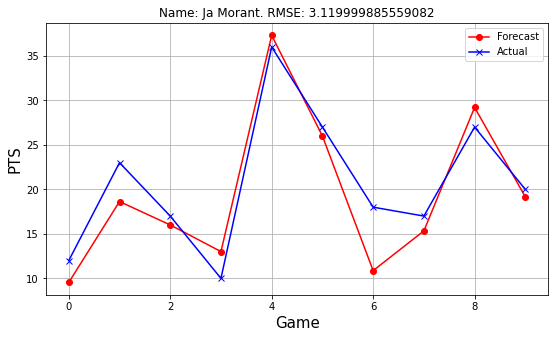

In [23]:
rmse = np.sqrt(mse(forecasts, ytest.reshape(-1, )))

plt.figure(figsize=(9, 5))
plt.plot(np.arange(len(ytest)), forecasts, color="red", marker="o", label="Forecast")
plt.plot(np.arange(len(ytest)), ytest.reshape(-1, ), color="blue", marker="x", label="Actual")
plt.xlabel("Game", fontsize=15)
plt.ylabel(label1[0], fontsize=15)
plt.title(f"Name: {name}. RMSE: {round(rmse, 2)}")
plt.grid()
plt.legend()
plt.show()

### GRU Test

In [24]:
xtrain_ = xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1])

In [25]:
gru = Sequential()

gru.add(GRU(200, return_sequences=True, unroll=True, input_shape=(1, xtrain_.shape[2])))
gru.add(Dropout(0.2))

gru.add(GRU(200, return_sequences=True, batch_size=24, recurrent_dropout=0.2,
            unroll=True, kernel_regularizer=regularizers.l1(1e-3)))
gru.add(Dropout(0.2))

gru.add(GRU(200, return_sequences=True, batch_size=24, recurrent_dropout=0.13,
            unroll=True, kernel_regularizer=regularizers.l2(1e-4)))

gru.add(Dense(1, ))

gru.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=Adam(learning_rate=4e-4),
              metrics="mse")

In [26]:
start = time()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-6, patience=15)

gru.fit(xtrain_, ytrain, batch_size=24, epochs=500, callbacks=[callback],
        verbose=0, validation_split=0.15, )

end = time()

print(f"Training time: {round(end - start, 2)}s")

Training time: 7.07s


In [27]:
gru_forecasts = gru.predict(xtest.reshape(xtest.shape[0], 1, xtest.shape[1]))
gru_forecasts = np.round(gru_forecasts.reshape(-1, ))

print(f"GRU Forecasts: {gru_forecasts}")
print()
print(f"Actual: {ytest.reshape(-1, )}")

GRU Forecasts: [10. 19. 16. 14. 36. 26. 12. 18. 30. 18.]

Actual: [12. 23. 17. 10. 36. 27. 18. 17. 27. 20.]


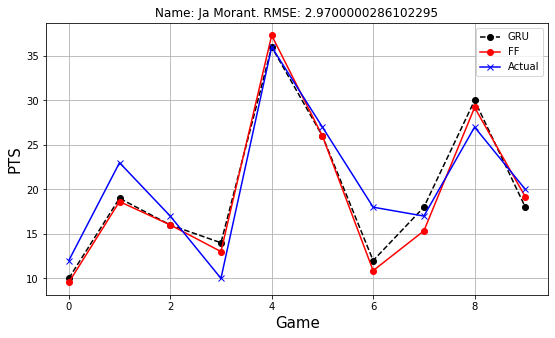

In [28]:
gru_rmse = np.sqrt(mse(gru_forecasts, ytest.reshape(-1, )))

plt.figure(figsize=(9, 5))
plt.plot(np.arange(len(ytest)), gru_forecasts, color="black", linestyle="--", marker="o", label="GRU")
plt.plot(np.arange(len(ytest)), forecasts, color="red", marker="o", label="FF")
plt.plot(np.arange(len(ytest)), ytest.reshape(-1, ), color="blue", marker="x", label="Actual")
plt.xlabel("Game", fontsize=15)
plt.ylabel(label1[0], fontsize=15)
plt.title(f"Name: {name}. RMSE: {round(gru_rmse, 2)}")
plt.grid()
plt.legend()
plt.show()

In [29]:
import xgboost as xgb

# xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=41)

# start = time()
# xgb_model.fit(xtrain, ytrain)
# end = time()
# print(f"XGBoost training time: {round(end-start, 2)}s")

In [34]:
training_data = xgb.DMatrix(xtrain[:-10], label=ytrain[:-10])
val_data = xgb.DMatrix(xtrain[-10:], label=ytrain[-10:])

evallist = [(val_data, 'evals')]
param = {"max_depth": 5, 'eta': 0.32, 'objective': "reg:linear",
         "alpha": 1e-3, "lambda": 1e-3,
         "nthread": 3, "eval_metric": "rmse"}
start = time()
xgb_model = xgb.train(param, training_data, 41, evallist)
end = time()
print(f"XGBoost training time: {round(end-start, 2)}s")

[08:41:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	evals-rmse:11.73788
[1]	evals-rmse:8.92565
[2]	evals-rmse:7.37446
[3]	evals-rmse:6.09966
[4]	evals-rmse:5.27122
[5]	evals-rmse:4.76024
[6]	evals-rmse:4.58725
[7]	evals-rmse:4.42967
[8]	evals-rmse:4.37923
[9]	evals-rmse:4.24815
[10]	evals-rmse:4.28133
[11]	evals-rmse:4.24785
[12]	evals-rmse:4.32545
[13]	evals-rmse:4.34538
[14]	evals-rmse:4.36183
[15]	evals-rmse:4.29357
[16]	evals-rmse:4.30652
[17]	evals-rmse:4.31718
[18]	evals-rmse:4.35934
[19]	evals-rmse:4.38863
[20]	evals-rmse:4.40066
[21]	evals-rmse:4.38932
[22]	evals-rmse:4.41361
[23]	evals-rmse:4.43240
[24]	evals-rmse:4.41738
[25]	evals-rmse:4.42230
[26]	evals-rmse:4.42616
[27]	evals-rmse:4.43116
[28]	evals-rmse:4.44045
[29]	evals-rmse:4.44743
[30]	evals-rmse:4.44664
[31]	evals-rmse:4.45039
[32]	evals-rmse:4.45954
[3

/Users/I541997/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [35]:
xgb_forecasts = np.round(xgb_model.predict(xgb.DMatrix(xtest)))

In [36]:
# xgb_forecasts = np.round(xgb_model.predict(xtest))

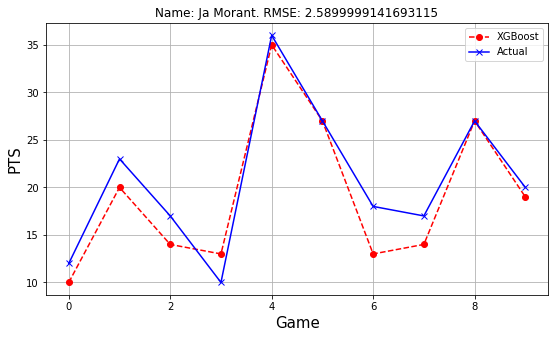

In [39]:
gru_rmse = np.sqrt(mse(xgb_forecasts, ytest.reshape(-1, )))

plt.figure(figsize=(9, 5))
plt.plot(np.arange(len(ytest)), xgb_forecasts, color="red", linestyle="--", marker="o", label="XGBoost")
# plt.plot(np.arange(len(ytest)), gru_forecasts, color="black", linestyle="--", marker="o", label="GRU")
# plt.plot(np.arange(len(ytest)), forecasts, color="red", marker="o", label="FF")
plt.plot(np.arange(len(ytest)), ytest.reshape(-1, ), color="blue", marker="x", label="Actual")
plt.xlabel("Game", fontsize=15)
plt.ylabel(label1[0], fontsize=15)
plt.title(f"Name: {name}. RMSE: {round(gru_rmse, 2)}")
plt.grid()
plt.legend()
plt.show()